In [1]:
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.tokenize import word_tokenize
import gensim.downloader
import io
from keras_preprocessing.text import tokenizer_from_json
from gensim.models import Word2Vec


D:\anaconda3\envs\tfgpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the seeder to have as stable random operations as possible

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
embedding_algorithms = ["w2v", "bert", "codebert"]
embedding_algorithm = embedding_algorithms[0]

In [4]:
representations = ["bow", "sequences"]
representation_form = representations[1]

In [5]:
# binary or multi-class
multi = True

In [6]:
train_w2v = False

Read data

In [7]:
if representation_form == "bow":
    data = pd.read_csv('bow_data.csv') # bow
else:
    data = pd.read_csv('sequences_data.csv') # sequences of tokens

In [8]:
data.head()

,Vulnerability,Category,Length
0,"f""str$id""""str$id""""str$id"" ...",sql_injection,9
1,client.listentcp() proxy = proxy(proxy_...,xsrf,8
2,"from django.http import httpresponse, httpresp...",open_redirect,9
3,"def write_preset(conn, queryin, descriptin):\t...",sql_injection,175
4,update_query = self.up...,sql_injection,14


In [9]:
if representation_form == "bow":
    bow_size = 237 # number of columns that stand as features

In [10]:
np.max(data["Length"])

392

In [11]:
if representation_form == "sequences":
    word_counts = data["Vulnerability"].apply(lambda x: len(x.split()))
    max_length = word_counts.max()
    print("Maximum number of words:", max_length)


Maximum number of words: 392


In [12]:
label_frequencies = data['Category'].value_counts()
print("Label Frequencies:\n", label_frequencies)
print("Total samples ", len(data))

Label Frequencies:
 sql_injection            1424
xsrf                      976
command_injection         721
path_disclosure           481
open_redirect             442
remote_code_execution     334
xss                       145
Name: Category, dtype: int64
Total samples  4523


In [13]:
if multi == True:
    n_categories = len(label_frequencies) # 7
    n_categories

Word Embedding

Word2Vec - load pre-trained word2vec embeddings - NL knowledge - static embeddings

In [14]:
if representation_form == "sequences":

    # Download the Punkt tokenizer models if not already downloaded
    nltk.download('punkt')

    tokenized_list = [word_tokenize(sentence) for sentence in data["Vulnerability"].tolist()]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iliaskaloup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BERT - load pre-trained bert embeddings - NL knowledge - contextual embeddings

In [15]:
if embedding_algorithm == "bert" and representation_form == "sequences": 
    model_variation = "bert-base-uncased" # "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_variation)
    bert = TFAutoModel.from_pretrained(model_variation)
    
    bert_embeddings = bert.get_input_embeddings()
    embedding_matrix = bert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    print(num_words)
    dim = len(embedding_matrix[0])
    print(dim)

In [16]:
if embedding_algorithm == "bert" and representation_form == "sequences":
    sentences = data["Vulnerability"].tolist()
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences] # Tokenize the complete sentences
    
    lines_pad = []
    for seq in sequences:
        lines_pad.append(seq[0])
    
    lines_pad = pad_sequences(lines_pad, padding = 'post', maxlen = 512)

CodeBERT - load pre-trained codebert embeddings - PL knowledge - contextual embeddings

In [17]:
if embedding_algorithm == "codebert" and representation_form == "sequences": 
    model_variation = "microsoft/codebert-base"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True)
    codebert = TFAutoModel.from_pretrained(model_variation)
    
    codebert_embeddings = codebert.get_input_embeddings()
    embedding_matrix = codebert_embeddings.weights[0].numpy()
    num_words = len(embedding_matrix)
    print(num_words)
    dim = len(embedding_matrix[0])
    print(dim)

In [18]:
def padSequences(sequences, max_len):
    lines_pad = []
    for sequence in sequences:
        seq = sequence['input_ids'].numpy()[0]
        if len(seq) < max_len:
            for i in range(len(seq), max_len):
                seq = np.append(seq, 0)
        lines_pad.append(seq)
    return lines_pad


In [19]:
if embedding_algorithm == "codebert" and representation_form == "sequences": 

    sentences = data["Vulnerability"].tolist()
    sequences = [tokenizer(sente, return_tensors="tf", truncation=True, add_special_tokens=False) for sente in sentences]
    
    lines_pad = padSequences(sequences, 512)
    lines_pad = [arr.tolist() for arr in lines_pad]
    lines_pad = np.array(lines_pad)

RNN model, LSTM specifically

In [20]:
def vectorize(words, w2v_vectors):
    words_vecs = [w2v_vectors[word] for word in words if word in w2v_vectors]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [21]:
w2v_vectors = gensim.downloader.load('word2vec-google-news-300')

Cross-Validation

Multi-class Classification: Categorization of all detected vulnerabilities

In [22]:
if multi == True:
    
    # Convert categories to numerical indexes
    category_numerical_indexes, unique_categories = data["Category"].factorize()

    # Create a dictionary mapping each category to its numerical index
    category_to_index = {category: index for index, category in enumerate(unique_categories)}

    # Update the categories in the DataFrame with their numerical indexes
    data["Category_Index"] = data["Category"].map(category_to_index)


Use DL models and sequences of tokens code representation

D:\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


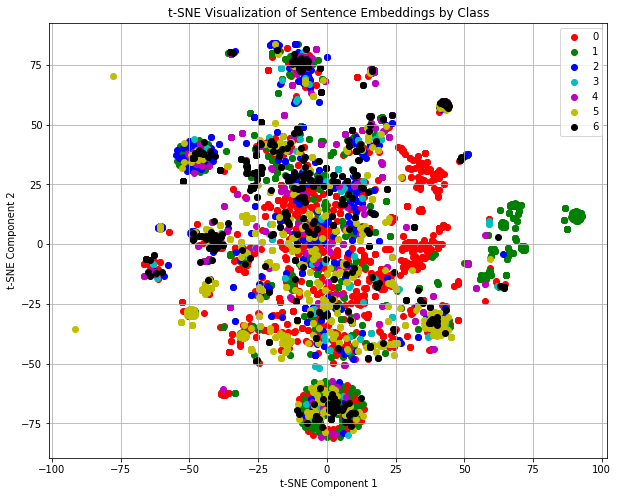

In [30]:
# T-SNE Plot
X = np.array(tokenized_list)
X = np.array([vectorize(sentence, w2v_vectors) for sentence in X])

y = data["Category_Index"].values

from sklearn.manifold import TSNE

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=seed)
embeddings_tsne = tsne.fit_transform(X)

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
class_labels = np.unique(y)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Example colors for each class

for i, class_label in enumerate(class_labels):
    indices = np.where(y == class_label)
    plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], c=colors[i], label=class_label)

plt.title('t-SNE Visualization of Sentence Embeddings by Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def runDLCrossVal_multi(X, y, w2v_vectors, max_len, seed):
    ############## cross validation
    scores=['accuracy', 'precision', 'recall', 'f1']
    values = [np.array([]) for i in range(0, len(scores))]
    score_dict = OrderedDict(zip(scores, values))
    k=10
    f=0
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    
    nb_epoch = 100
    BS = 64
    print("Training...")
    milli_sec1 = int(round(time.time() * 1000))
    
    for train_index, test_index in kfold.split(X, y):
        f = f + 1
        print('fold number= ',f)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        
        X_train = np.array([vectorize(sentence, w2v_vectors) for sentence in X_train])
        X_test = np.array([vectorize(sentence, w2v_vectors) for sentence in X_test])
        
#         Y_train = np.array(Y_train)
#         Y_train = Y_train.ravel()
#         Y_test = np.array(Y_test)
#         Y_test = Y_test.ravel()
        
#         #sampling
#         X_res, Y_res = RandomOverSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)
#         #X_res, Y_res = RandomUnderSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)
    
#         #shuffle dataset
#         X_resampled=pd.DataFrame(X_res)
#         Y_resampled=pd.DataFrame(Y_res)
#         newTrain=X_resampled.assign(Label=Y_resampled.values)
#         newTrain = shuffle(newTrain,random_state=seed)
#         X_train=np.array(newTrain.iloc[:, 0:-1 ])
#         X_train=pd.DataFrame(X_train)
#         Y_train=np.array(newTrain.iloc[:, -1 ])
#         Y_train=pd.DataFrame(Y_train)
        
        myModel = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
        
        myModel.fit(X_train, Y_train.ravel())
        
        predictions = myModel.predict(X_test)
        #predScores = myModel.predict_proba(X_test)
        accuracy=accuracy_score(Y_test, predictions)
        precision=precision_score(Y_test, predictions, average='macro')
        recall=recall_score(Y_test, predictions, average='macro')
        f1=f1_score(Y_test, predictions, average='macro')
        conf_matrix = confusion_matrix(Y_test, predictions)
        print(conf_matrix)
        print("Accuracy:%.2f%%"%(accuracy*100))
        print("Precision:%.2f%%"%(precision*100))
        print("Recall:%.2f%%"%(recall*100))
        print("F1 score:%.2f%%"%(f1*100))
        print(classification_report(Y_test, predictions))
        del myModel
        score_dict['accuracy'] = np.append(score_dict['accuracy'], accuracy)
        score_dict['precision'] = np.append(score_dict['precision'], precision)
        score_dict['recall'] = np.append(score_dict['recall'], recall)
        score_dict['f1'] = np.append(score_dict['f1'], f1)
        
    milli_sec2 = int(round(time.time() * 1000))
    print("Cross Validation is completed after", milli_sec2-milli_sec1)
    
    print("accuracy: %.2f%% (%.2f%%)" % (score_dict['accuracy'].mean()*100, score_dict['accuracy'].std()*100))
    print("precision: %.2f%% (%.2f%%)" % (score_dict['precision'].mean()*100, score_dict['precision'].std()*100))
    print("recall: %.2f%% (%.2f%%)" % (score_dict['recall'].mean()*100, score_dict['recall'].std()*100))
    print("f1: %.2f%% (%.2f%%)" % (score_dict['f1'].mean()*100, score_dict['f1'].std()*100))


In [25]:
if multi == True and representation_form == "sequences" and train_w2v == False:
    runDLCrossVal_multi(np.array(tokenized_list), data["Category_Index"].values, w2v_vectors, 512, seed)

D:\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Training...
fold number=  1
[[128   6   1   1   0   3   4]
 [ 22  62   2   0   2   6   3]
 [ 13   7  21   0   0   0   4]
 [  4   3   0   6   0   0   1]
 [  9   3   0   0  17   0   5]
 [ 16   3   1   0   2  48   2]
 [ 12   5   1   0   1   0  29]]
Accuracy:68.65%
Precision:68.65%
Recall:68.65%
F1 score:68.65%
              precision    recall  f1-score   support

           0       0.63      0.90      0.74       143
           1       0.70      0.64      0.67        97
           2       0.81      0.47      0.59        45
           3       0.86      0.43      0.57        14
           4       0.77      0.50      0.61        34
           5       0.84      0.67      0.74        72
           6       0.60      0.60      0.60        48

    accuracy                           0.69       453
   macro avg       0.74      0.60      0.65       453
weighted avg       0.71      0.69      0.68       453

fold number=  2
[[125   9   3   0   1   3   2]
 [ 18  66   4   0   0   5   4]
 [  9  10  23   

One more option for training your own word2vec vectors

In [28]:
def trainWord2Vec(tokenized_list, max_length, dim):
    # this should be executed only in the training set during cross-validation
    w2v_model = Word2Vec(sentences=tokenized_list, vector_size=dim, window=5, min_count=1, workers=4, epochs=4)
    #w2v_model.save("python_word2vec.model")
    #w2v_model = Word2Vec.load("python_word2vec.model")

    #     fileEmb = 'w2v_embeddingsIters.txt'
    #     w2v_vectors.save_word2vec_format(fileEmb, binary=False)

    #     embeddings_index = {}
    #     f = open(os.path.join('', fileEmb), encoding="utf-8")
    #     for line in f:    
    #         values = line.split()
    #         word = values[0]
    #         coefs = np.asarray(values[1:])
    #         embeddings_index[word] = coefs   
    #     f.close()


    tokenizer_obj = Tokenizer()   
    tokenizer_obj.fit_on_texts(tokenized_list)

    tokenizer_json = tokenizer_obj.to_json()
    tokenizerFile = 'w2v_new_tokenizer.json'
    with io.open(tokenizerFile, 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))

    with open(tokenizerFile) as f:
        dataTokenizer = json.load(f)
        tokenizer_obj = tokenizer_from_json(dataTokenizer)

    sequences = tokenizer_obj.texts_to_sequences(tokenized_list)
    word_index = tokenizer_obj.word_index

    lines_pad = pad_sequences(sequences, padding = 'post', maxlen = max_length)


    num_words = len(word_index) + 1 # +1 for the unknown-zeros
    embedding_matrix = np.zeros((num_words, dim))
    for word, i in word_index.items():
        if i > num_words:
            continue
        #embedding_vector = embeddings_index.get(word)
        embedding_vector = w2v_model.wv[word] if word in w2v_model.wv else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return lines_pad, embedding_matrix, num_words, tokenizerFile


In [29]:
def testWord2Vec(tokenized_list, tokenizer_path, max_length):
    
    with open(tokenizer_path) as f:
        dataTokenizer = json.load(f)
        tokenizer_obj = tokenizer_from_json(dataTokenizer)
        
    sequences = tokenizer_obj.texts_to_sequences(tokenized_list)
    
    lines_pad = pad_sequences(sequences, padding = 'post', maxlen = max_length)
    
    return lines_pad

In [37]:
def runDLCrossValW2v_multi(X, y, max_len, dim, seed):
    ############## cross validation
    scores=['accuracy', 'precision', 'recall', 'f1']
    values = [np.array([]) for i in range(0, len(scores))]
    score_dict = OrderedDict(zip(scores, values))
    k=10
    f=0
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    
    nb_epoch = 100
    BS = 64
    print("Training...")
    milli_sec1 = int(round(time.time() * 1000))
    
    for train_index, test_index in kfold.split(X, y):
        f = f + 1
        print('fold number= ',f)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        
        X_train, embedding_matrix, num_words, tokenizerFile = trainWord2Vec(X_train, max_len, dim)
        
        X_test = testWord2Vec(X_test, tokenizerFile, max_len)
        
#         Y_train = np.array(Y_train)
#         Y_train = Y_train.ravel()
#         Y_test = np.array(Y_test)
#         Y_test = Y_test.ravel()
        
#         #sampling
#         X_res, Y_res = RandomOverSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)
#         #X_res, Y_res = RandomUnderSampler(random_state=seed, sampling_strategy=0.5).fit_resample(X_train, Y_train)
    
#         #shuffle dataset
#         X_resampled=pd.DataFrame(X_res)
#         Y_resampled=pd.DataFrame(Y_res)
#         newTrain=X_resampled.assign(Label=Y_resampled.values)
#         newTrain = shuffle(newTrain,random_state=seed)
#         X_train=np.array(newTrain.iloc[:, 0:-1 ])
#         X_train=pd.DataFrame(X_train)
#         Y_train=np.array(newTrain.iloc[:, -1 ])
#         Y_train=pd.DataFrame(Y_train)
        
        if userModel == "lstm":
            myModel = buildLstm(max_len, num_words, dim, seed, embedding_matrix, n_categories)
        print("model summary\m",myModel.summary())
        csv_logger = CSVLogger('log.csv', append=True, separator=',')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
        
        history = myModel.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = nb_epoch, batch_size = BS, shuffle=False, verbose=1, callbacks=[csv_logger,es,mc])
        
        
        #load best model
        #model = load_model('best_model.h5')
        myModel.load_weights("best_model.h5")
        
        scores = myModel.evaluate(X_test, Y_test, verbose=0)
        #predictions = myModel.predict_classes(X_test, verbose=0)
        predScores = myModel.predict(X_test)
        predictions = np.argmax(predScores, axis=1)
        accuracy=accuracy_score(Y_test, predictions)
        precision=precision_score(Y_test, predictions, average='macro')
        recall=recall_score(Y_test, predictions, average='macro')
        f1=f1_score(Y_test, predictions, average='macro')
        conf_matrix = confusion_matrix(Y_test, predictions)
        print(conf_matrix)
        print("Accuracy:%.2f%%"%(accuracy*100))
        print("Precision:%.2f%%"%(precision*100))
        print("Recall:%.2f%%"%(recall*100))
        print("F1 score:%.2f%%"%(f1*100))
        print(classification_report(Y_test, predictions))
        del myModel
        score_dict['accuracy'] = np.append(score_dict['accuracy'], accuracy)
        score_dict['precision'] = np.append(score_dict['precision'], precision)
        score_dict['recall'] = np.append(score_dict['recall'], recall)
        score_dict['f1'] = np.append(score_dict['f1'], f1)
        
    milli_sec2 = int(round(time.time() * 1000))
    print("Cross Validation is completed after", milli_sec2-milli_sec1)
    
    print("accuracy: %.2f%% (%.2f%%)" % (score_dict['accuracy'].mean()*100, score_dict['accuracy'].std()*100))
    print("precision: %.2f%% (%.2f%%)" % (score_dict['precision'].mean()*100, score_dict['precision'].std()*100))
    print("recall: %.2f%% (%.2f%%)" % (score_dict['recall'].mean()*100, score_dict['recall'].std()*100))
    print("f1: %.2f%% (%.2f%%)" % (score_dict['f1'].mean()*100, score_dict['f1'].std()*100))


In [38]:
if train_w2v == True and multi == True and representation_form == "sequences":
    dim = 300
    runDLCrossValW2v_multi(np.array(tokenized_list), data["Category_Index"].values, 512, dim, seed)